
# Step 2 — Black‑Box Model (XGBoost) for Default Prediction

This notebook trains an XGBoost classifier to forecast **default** (binary `target`) for the course project **Interpretability, Stability, and Algorithmic Fairness (Fall 2025)**.

**What this notebook does**
- Loads the project dataset
- Cleans & preprocesses features (numeric + categorical)
- Trains an XGBoost model with early stopping
- Evaluates with ROC‑AUC, PR‑AUC, F1, confusion matrix
- Saves predictions and the fitted model for later steps

> Note: Columns that could leak information from Step 1 (e.g., `'Predictions'`, `'Predicted probabilities'`) are **dropped** on load.


## 0. Setup

In [1]:

# If needed, install dependencies (uncomment as necessary)
# %pip install -q xgboost scikit-learn pandas numpy matplotlib joblib

import os
import gc
import math
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    roc_curve, classification_report, confusion_matrix
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1. Configuration

In [2]:

# --- Paths ---
# Prefer a local file first; fall back to /mnt/data if running in a hosted environment.

DATA_PATH = '/Users/chenzhipeng/Desktop/X/Cours/Interpretability/group_project/Algo_fairness-Group-Project/data/raw/dataproject2025.csv'

# --- Basic run params ---
TEST_SIZE = 0.20            # 80/20 stratified split
USE_SAMPLE = False          # set True for quick tests (e.g., 50_000 rows)
SAMPLE_N = 50_000

# Whether to EXCLUDE sensitive attributes from features (you can toggle later for Step 9 fairness analysis)
EXCLUDE_SENSITIVE = False
SENSITIVE_COLS = [
    "Pct_afro_american"    # protected attribute proxy provided in the dataset
]

print(f"Using DATA_PATH = {DATA_PATH}")


Using DATA_PATH = /Users/chenzhipeng/Desktop/X/Cours/Interpretability/group_project/Algo_fairness-Group-Project/data/raw/dataproject2025.csv


## 2. Load data

In [3]:

# Read CSV (large-friendly). We'll downcast floats to float32 to reduce memory.
read_kwargs = dict(low_memory=False)
df = pd.read_csv(DATA_PATH, **read_kwargs)

if USE_SAMPLE and len(df) > SAMPLE_N:
    df = df.sample(SAMPLE_N, random_state=RANDOM_STATE).reset_index(drop=True)

print(df.shape)
display(df.head(3))
print("\nColumns:", list(df.columns))


(1086236, 39)


,Unnamed: 0,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length,...,purpose,revol_bal,revol_util,sub_grade,target,tax_liens,zip_code,Pct_afro_american,Predictions,Predicted probabilities
0,0,2013,0,39600.0,1379.0,21564.0,16.1,0.0,2.49,2 years,...,home_improvement,4136.0,16.1,B2,0,0.0,782,7.388592,0,0.053051
1,1,2013,0,55000.0,9570.0,16473.0,53.9,0.0,22.87,10+ years,...,debt_consolidation,36638.0,61.2,B2,0,0.0,481,9.745456,0,0.084507
2,2,2013,0,325000.0,53306.0,13901.0,67.1,0.0,18.55,5 years,...,debt_consolidation,29581.0,54.6,A3,0,0.0,945,7.542862,0,0.037206



Columns: ['Unnamed: 0', 'issue_d', 'loan duration', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'emp_length', 'emp_title', 'fico_range_high', 'funded_amnt', 'grade', 'home_ownership', 'inq_last_6mths', 'int_rate', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl', 'num_rev_accts', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'target', 'tax_liens', 'zip_code', 'Pct_afro_american', 'Predictions', 'Predicted probabilities']


## 3. Basic cleaning & target

In [4]:

# Drop known leak / index columns if present
LEAKY_COLS = [
    "Predictions", "Predicted probabilities", "DP", "dp", 
    "Unnamed: 0", "id", "ID", "index"
]
present_leaky = [c for c in LEAKY_COLS if c in df.columns]
df = df.drop(columns=present_leaky, errors="ignore")

# Target
assert "target" in df.columns, "Expected 'target' column not found."
df["target"] = df["target"].astype(int)

# Optional: exclude sensitive columns for Step 2 (toggle above)
if EXCLUDE_SENSITIVE:
    drop_sens = [c for c in SENSITIVE_COLS if c in df.columns]
    if drop_sens:
        df = df.drop(columns=drop_sens)

print("After drops:", df.shape)
df.head(2)


After drops: (1086236, 36)


,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length,emp_title,...,pub_rec,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,target,tax_liens,zip_code,Pct_afro_american
0,2013,0,39600.0,1379.0,21564.0,16.1,0.0,2.49,2 years,other,...,0.0,0.0,home_improvement,4136.0,16.1,B2,0,0.0,782,7.388592
1,2013,0,55000.0,9570.0,16473.0,53.9,0.0,22.87,10+ years,other,...,0.0,0.0,debt_consolidation,36638.0,61.2,B2,0,0.0,481,9.745456


## 4. Feature engineering

In [5]:

def parse_emp_length(val):
    '''
    Convert employment length strings to numeric years.
    Examples: '10+ years'->10, '< 1 year'->0.5, '3 years'->3, NaN->np.nan
    '''
    if pd.isna(val):
        return np.nan
    s = str(val).strip().lower()
    if s in {"< 1 year", "less than 1 year", "<1 year"}:
        return 0.5
    if s in {"10+ years", "10+ yrs", "10+yr"}:
        return 10.0
    # Extract any leading integer
    for tok in s.replace("+","").split():
        try:
            return float(int(tok))
        except:
            continue
    try:
        return float(s)
    except:
        return np.nan

def parse_loan_duration(val):
    '''
    Convert '36 months' -> 36, '60 months' -> 60, already numeric -> itself.
    '''
    if pd.isna(val):
        return np.nan
    if isinstance(val, (int, float)):
        return float(val)
    s = str(val).strip().lower().replace("months","").replace("month","").strip()
    try:
        return float(s)
    except:
        return np.nan

# Apply parsers if columns exist
if "emp_length" in df.columns:
    df["emp_length_parsed"] = df["emp_length"].apply(parse_emp_length)
if "loan duration" in df.columns:
    df["loan_duration_parsed"] = df["loan duration"].apply(parse_loan_duration)

# If 'issue_d' is a date-like string or year, keep numeric
if "issue_d" in df.columns:
    # If looks numeric (e.g., 2013.0), keep as float; else parse to ordinal
    if df["issue_d"].dtype == object:
        try:
            d = pd.to_datetime(df["issue_d"], errors="coerce")
            df["issue_d_ordinal"] = d.map(lambda x: x.toordinal() if pd.notna(x) else np.nan)
        except:
            pass
    else:
        # leave numeric year/month values as-is
        pass

# Identify feature columns
target_col = "target"
all_features = [c for c in df.columns if c != target_col]

# Separate numeric vs categorical by dtype (object -> categorical). We'll skip free-text high-cardinality fields.
high_cardinality_text = {"emp_title"}  # can revisit with hashing later
features = [c for c in all_features if c not in high_cardinality_text]

numeric_cols = [c for c in features if pd.api.types.is_numeric_dtype(df[c])]
categorical_cols = [c for c in features if c not in numeric_cols]

print("Numeric:", len(numeric_cols), "Categorical:", len(categorical_cols))


Numeric: 31 Categorical: 5


## 5. Train / validation split

In [6]:

X = df[numeric_cols + categorical_cols].copy()
y = df[target_col].copy()

# Ensure numeric types are float32 to reduce memory footprint
for c in numeric_cols:
    X[c] = pd.to_numeric(X[c], errors="coerce").astype("float32")

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, " Test:", X_test.shape)
print("Default rate (train):", y_train.mean().round(4), " (test):", y_test.mean().round(4))


Train: (868988, 36)  Test: (217248, 36)
Default rate (train): 0.2105  (test): 0.2105


## 6. Model: XGBoost

In [7]:
# Preprocess
numeric_transformer = SimpleImputer(strategy="median")

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    sparse_threshold=0.3  # keep sparse matrices when many categories
)

# Class imbalance handling via scale_pos_weight = (neg/pos)
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = float(neg / max(pos, 1))

xgb = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    min_child_weight=1.0,
    objective="binary:logistic",
    tree_method="hist",
    random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    early_stopping_rounds=50
)

# Early stopping with a validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.15, stratify=y_train, random_state=RANDOM_STATE
)

model = Pipeline(steps=[
    ("prep", preprocess),
    ("xgb", xgb)
])

# Fit with early stopping (pass eval_set to underlying xgb via fit_params)
# We need to transform X_val with the preprocessor to feed to xgb for eval_set
prep = preprocess.fit(X_tr, y_tr)
X_tr_t = prep.transform(X_tr)
X_val_t = prep.transform(X_val)

xgb.fit(
    X_tr_t, y_tr, # Using your transformed data
    eval_set=[(X_val_t, y_val)],
    verbose=False, # Control verbosity here
  #  callbacks=[EarlyStopping(rounds=50)] # Callback only needs the number of rounds
)

# Wrap back into a single pipeline for convenience (prep is already fitted; xgb is fitted).
from sklearn.base import BaseEstimator, TransformerMixin
class PretrainedPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, fitted_preprocessor):
        self.fitted = fitted_preprocessor
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return self.fitted.transform(X)

final_model = Pipeline(steps=[
    ("prep", PretrainedPreprocessor(prep)),
    ("xgb", xgb)
])

try:
    best_ntree = xgb.get_booster().best_ntree_limit
except Exception:
    best_ntree = "n/a"
print("Best n_estimators (limit):", best_ntree)


Best n_estimators (limit): n/a


## 7. Evaluation

ROC-AUC: 0.7237 | PR-AUC: 0.4114

              precision    recall  f1-score   support

           0     0.8788    0.6692    0.7598    171518
           1     0.3451    0.6538    0.4518     45730

    accuracy                         0.6660    217248
   macro avg     0.6119    0.6615    0.6058    217248
weighted avg     0.7664    0.6660    0.6950    217248

Confusion Matrix:
 [[114782  56736]
 [ 15832  29898]]


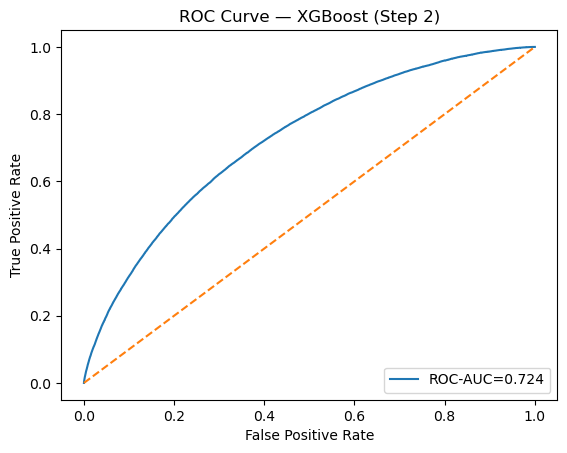

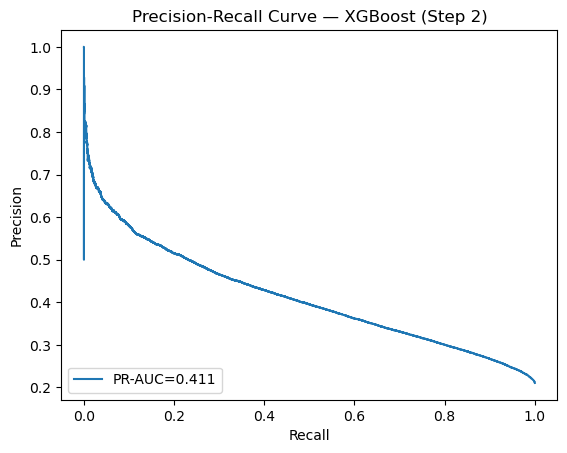

In [8]:

# Predict
X_test_t = prep.transform(X_test)
proba = xgb.predict_proba(X_test_t)[:, 1]
pred = (proba >= 0.5).astype(int)

# Metrics
roc_auc = roc_auc_score(y_test, proba)
pr_auc = average_precision_score(y_test, proba)
print(f"ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f}\n")

print(classification_report(y_test, pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, pred)
print("Confusion Matrix:\n", cm)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC-AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — XGBoost (Step 2)")
plt.legend(loc="lower right")
plt.show()

# PR Curve
prec, rec, _ = precision_recall_curve(y_test, proba)
plt.figure()
plt.plot(rec, prec, label=f"PR-AUC={pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve — XGBoost (Step 2)")
plt.legend(loc="lower left")
plt.show()


## 8. Feature importance (gain)

,feature,gain
42,grade_A,723.415771
30,loan_duration_parsed,489.243073
43,grade_B,286.718414
11,int_rate,250.401810
1,loan duration,245.430176
44,grade_C,186.161560
51,home_ownership_RENT,78.122635
0,issue_d,64.563080
45,grade_D,54.261425
49,home_ownership_MORTGAGE,46.636276


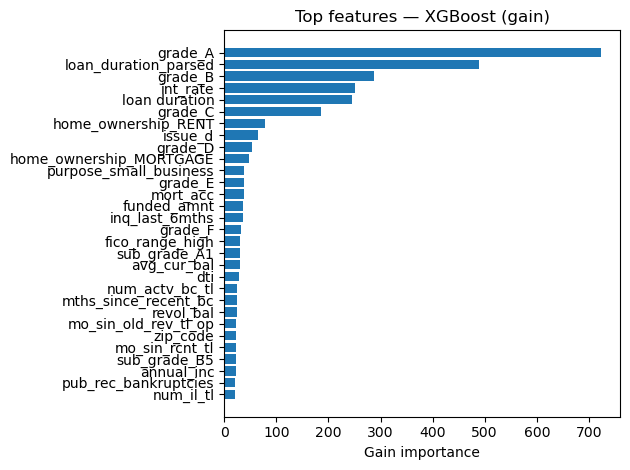

In [9]:

# Map feature names through the fitted preprocessor (OHE expands categories)
ohe = prep.named_transformers_["cat"].named_steps["ohe"] if len(categorical_cols) else None
num_feature_names = numeric_cols
cat_feature_names = list(ohe.get_feature_names_out(categorical_cols)) if ohe is not None else []
feature_names = list(num_feature_names) + cat_feature_names

booster = xgb.get_booster()
# XGBoost importance is keyed by f0, f1, ...
score_map = booster.get_score(importance_type="gain")

# Convert to a sorted DataFrame
imp = pd.DataFrame(
    [(int(k[1:]), v) for k,v in score_map.items()],
    columns=["index","gain"]
).sort_values("gain", ascending=False)

imp["feature"] = imp["index"].map(lambda i: feature_names[i] if i < len(feature_names) else f"f{i}")
topk = imp.head(30)[["feature","gain"]]
display(topk)

plt.figure()
plt.barh(topk["feature"][::-1], topk["gain"][::-1])
plt.xlabel("Gain importance")
plt.title("Top features — XGBoost (gain)")
plt.tight_layout()
plt.show()


## 9. Save artifacts

In [10]:
import datetime
out_dir = "outputs_step2"
os.makedirs(out_dir, exist_ok=True)

model_path = os.path.join(out_dir, "xgb_step2_model.joblib")
preds_path = os.path.join(out_dir, "xgb_step2_test_predictions.csv")
meta_path  = os.path.join(out_dir, "xgb_step2_meta.txt")

# Save model and predictions
joblib.dump(final_model, model_path)


preds_df = pd.DataFrame({
    "y_true": y_test.values,
    "y_proba": proba,
    "y_pred": pred
})
preds_df.to_csv(preds_path, index=False)

with open(meta_path, "w") as f:
    f.write(f"Saved: {datetime.datetime.now().isoformat()}\n")
    f.write(f"Data path: {DATA_PATH}\n")
    f.write(f"Train shape: {X_train.shape} | Test shape: {X_test.shape}\n")
    f.write(f"ROC-AUC: {roc_auc:.6f} | PR-AUC: {pr_auc:.6f}\n")
    f.write(f"Scale_pos_weight: {scale_pos_weight}\n")
    f.write(f"Excluded sensitive cols: {EXCLUDE_SENSITIVE}\n")

print("Artifacts saved to:", out_dir)
print(" -", model_path)
print(" -", preds_path)
print(" -", meta_path)


Artifacts saved to: outputs_step2
 - outputs_step2/xgb_step2_model.joblib
 - outputs_step2/xgb_step2_test_predictions.csv
 - outputs_step2/xgb_step2_meta.txt


# Step 10 — FPDP using a Fairness Measure
# Statistical Parity PDP with p-values & XY/XD dependence map

In [10]:
# ============================================
# Step 10 — FPDP using a Fairness Measure
# Statistical Parity PDP with p-values & XY/XD dependence map
# ============================================

import os
import math
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Tuple, Dict

from sklearn.utils import check_random_state
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

# ----------------------------
# Config (edit as needed)
# ----------------------------
DATA_PATH   = "/Users/chenzhipeng/Desktop/X/Cours/Interpretability/group_project/Algo_fairness-Group-Project/data/raw/dataproject2025.csv"
MODEL_PATH  = "/Users/chenzhipeng/Desktop/X/Cours/Interpretability/group_project/Algo_fairness-Group-Project/outputs_step2/xgb_step2_model.joblib"
OUT_DIR     = "artifacts_step10/fpdp"

# Fairness PDP targets (you can include many; the code is generic)
FPDP_FEATURES = [
    "int_rate",
    "funded_amnt",
    "loan duration",
    "issue_d",
    "dti",
    # add more features here if you want
]

# Numeric grid (quantiles, in percentage)
NUM_Q = [5, 25, 50, 75, 95]

# Bootstrap for CI and p-values at each grid point
N_BOOT = 500
ALPHA  = 0.05
RNG_SEED = 42

# Dependence map settings
# For categorical features we will treat them as discrete for MI.
MAX_CAT_LEVELS = None  # None -> use all levels; or set an int to cap top-K frequent levels

# ----------------------------
# Helpers
# ----------------------------
from sklearn.base import BaseEstimator, TransformerMixin

class PretrainedPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, fitted_preprocessor=None):
        self.fitted = fitted_preprocessor
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # delegate to the stored fitted preprocessor
        return self.fitted.transform(X)
    
    
def ensure_outdir(path: str):
    os.makedirs(path, exist_ok=True)

def is_numeric_series(s: pd.Series) -> bool:
    return pd.api.types.is_numeric_dtype(s)

def make_protected_indicator(df: pd.DataFrame, col: str) -> np.ndarray:
    """
    Binarize protected attribute by median: D=1 if value > median, else 0.
    Missing values are imputed by column median before binarization.
    """
    vec = pd.to_numeric(df[col], errors="coerce")
    med = np.nanmedian(vec.values)
    vec = vec.fillna(med)
    D = (vec.values > med).astype(int)
    return D

def quantile_grid(values: pd.Series, q_list: List[float]) -> np.ndarray:
    """Return unique sorted quantile grid values (remove duplicates)."""
    q = np.unique(np.clip(q_list, 0, 100))
    grid = np.unique(np.nanpercentile(values.astype(float), q))
    return grid

def categorical_grid(values: pd.Series, max_levels: int = MAX_CAT_LEVELS) -> List:
    """
    Return category levels sorted by frequency desc; optionally cap to top-K.
    """
    vc = values.astype("object").fillna("<<MISSING>>").value_counts(dropna=False)
    levels = vc.index.tolist()
    if (max_levels is not None) and (len(levels) > max_levels):
        levels = levels[:max_levels]
    return levels

def bootstrap_sp_diff(
    yhat: np.ndarray, D: np.ndarray, n_boot: int = 500, rng=None
) -> Tuple[float, Tuple[float, float], float]:
    """
    Statistical Parity difference with bootstrap CI and two-sided p-value.
    yhat: predicted probabilities for all samples given "feature fixed at x_s"
    D:    binary protected attribute indicator (0/1) for all samples

    Returns:
      (sp_diff, (ci_low, ci_high), p_value)
    """
    if rng is None:
        rng = check_random_state(None)

    # observed difference
    mu1 = yhat[D == 1].mean() if (D == 1).any() else np.nan
    mu0 = yhat[D == 0].mean() if (D == 0).any() else np.nan
    diff = mu1 - mu0

    # bootstrap
    n = len(yhat)
    boot = []
    for _ in range(n_boot):
        idx = rng.randint(0, n, size=n)
        yy  = yhat[idx]
        dd  = D[idx]
        m1 = yy[dd == 1].mean() if (dd == 1).any() else np.nan
        m0 = yy[dd == 0].mean() if (dd == 0).any() else np.nan
        boot.append(m1 - m0)
    boot = np.array(boot)

    # CI
    ci_low, ci_high = np.nanpercentile(boot, [100*ALPHA/2, 100*(1-ALPHA/2)])

    # two-sided p-value (H0: diff == 0)
    # proportion of |boot| >= |diff|
    p = np.mean(np.abs(boot - np.nanmean(boot)) >= np.abs(diff))

    return float(diff), (float(ci_low), float(ci_high)), float(p)

def dependence_xy_xd(
    df: pd.DataFrame, feature: str, y_true: np.ndarray, D: np.ndarray
) -> Tuple[float, float]:
    """
    Compute dependence scores for the scatter plot:
      - X/Y dependence: mutual information I(X;Y)
      - X/D dependence: mutual information I(X;D)

    Fix: For categorical (object) features, factorize to integer codes so that
    mutual_info_classif receives numeric arrays (required by sklearn).
    """
    x = df[feature]

    if not is_numeric_series(x):
        # Treat as categorical: convert to string, fill missing, and factorize to int codes
        vals = x.astype("object").fillna("<<MISSING>>")
        codes, _ = pd.factorize(vals, sort=True)  # int64 codes 0..K-1
        X_ = codes.reshape(-1, 1)
        discrete_mask = np.array([True])          # tell MI that this feature is discrete
    else:
        # Numeric path: coerce, impute with median, keep as float
        cont = pd.to_numeric(x, errors="coerce")
        cont = cont.fillna(cont.median())
        X_ = cont.values.reshape(-1, 1)
        discrete_mask = np.array([False])

    mi_xy = mutual_info_classif(
        X_, y_true.astype(int),
        discrete_features=discrete_mask,
        random_state=RNG_SEED
    )[0]

    mi_xd = mutual_info_classif(
        X_, D.astype(int),
        discrete_features=discrete_mask,
        random_state=RNG_SEED
    )[0]

    return float(mi_xy), float(mi_xd)

# ---- add: feature engineering identical to Step 2 ----
def parse_emp_length(val):
    if pd.isna(val):
        return np.nan
    s = str(val).strip().lower()
    if s in {"< 1 year", "less than 1 year", "<1 year"}:
        return 0.5
    if s in {"10+ years", "10+ yrs", "10+yr"}:
        return 10.0
    for tok in s.replace("+","").split():
        try:
            return float(int(tok))
        except Exception:
            continue
    try:
        return float(s)
    except Exception:
        return np.nan

def parse_loan_duration(val):
    if pd.isna(val):
        return np.nan
    if isinstance(val, (int, float)):
        return float(val)
    s = str(val).strip().lower().replace("months","").replace("month","").strip()
    try:
        return float(s)
    except Exception:
        return np.nan

def add_step2_engineered_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Recreate the engineered columns used when fitting the pipeline."""
    if "emp_length" in df.columns and "emp_length_parsed" not in df.columns:
        df["emp_length_parsed"] = df["emp_length"].apply(parse_emp_length)
    if "loan duration" in df.columns and "loan_duration_parsed" not in df.columns:
        df["loan_duration_parsed"] = df["loan duration"].apply(parse_loan_duration)

    if "issue_d" in df.columns and "issue_d_ordinal" not in df.columns:
        if df["issue_d"].dtype == object:
            d = pd.to_datetime(df["issue_d"], errors="coerce")
            df["issue_d_ordinal"] = d.map(lambda x: x.toordinal() if pd.notna(x) else np.nan)
        else:
            # keep numeric as-is (train step allowed numeric)
            df["issue_d_ordinal"] = df["issue_d"]
    return df

# ----------------------------
# Main FPDP compute functions
# ----------------------------
def fpdp_for_feature(
    base_df: pd.DataFrame,
    model,
    feature: str,
    D: np.ndarray,
    num_quantiles: List[int] = NUM_Q,
    n_boot: int = N_BOOT,
    rng_seed: int = RNG_SEED,
) -> pd.DataFrame:
    """
    Compute FPDP table for one feature:
      - grid_x: grid value for X_s
      - sp_diff: Statistical Parity difference at that grid
      - ci_low, ci_high: bootstrap CI
      - p_value: two-sided bootstrap p-value
      - n_group0, n_group1: group sizes (sanity info)
    """
    rng = check_random_state(rng_seed)
    x = base_df[feature]

    if is_numeric_series(x):
        grid = quantile_grid(pd.to_numeric(x, errors="coerce"), num_quantiles)
        grid_labels = [float(v) for v in grid]
    else:
        grid = categorical_grid(x, max_levels=MAX_CAT_LEVELS)
        grid_labels = [str(v) for v in grid]

    rows = []
    for g_val, glabel in zip(grid, grid_labels):
        df_mod = base_df.copy()

        # Set all rows' feature to the grid value (classic PDP intervention)
        df_mod[feature] = g_val

        # Predict probabilities with the fitted pipeline (preprocess + xgb)
        yhat = model.predict_proba(df_mod)[:, 1]

        # Statistical Parity diff + CI + p
        diff, (lo, hi), p = bootstrap_sp_diff(yhat, D, n_boot=n_boot, rng=rng)

        is_sig = (lo > 0.0) or (hi < 0.0)

        rows.append({
            "feature": feature,
            "grid_x": glabel,
            "sp_diff": diff,
            "ci_low": lo,
            "ci_high": hi,
            "p_value": p,          # kept for reference; you can drop this column if you want
            "significant": bool(is_sig),
            "n_group0": int((D == 0).sum()),
            "n_group1": int((D == 1).sum())
        })

    return pd.DataFrame(rows)

def plot_fpdp_pvalues(df_fpdp: pd.DataFrame, feature: str, out_path: str):
    """
    Bar plot of p-values across grid points for a given feature,
    with a red horizontal line at alpha.
    """
    sub = df_fpdp[df_fpdp["feature"] == feature].copy()
    xlab = sub["grid_x"].astype(str).tolist()
    pval = sub["p_value"].values

    plt.figure(figsize=(4, 3))
    plt.bar(range(len(xlab)), pval)
    plt.axhline(ALPHA, color="red", linewidth=2)
    plt.xticks(range(len(xlab)), xlab, rotation=45, ha="right")
    plt.ylabel("p-value")
    plt.title(feature)
    plt.tight_layout()
    plt.savefig(out_path, dpi=180)
    plt.close()

def plot_dependence_scatter(dep_table: pd.DataFrame, out_path: str, highlight: List[str] = None):
    """
    Scatter of X/Y vs X/D dependence (mutual information).
    If `highlight` is provided (list of feature names), those points are
    drawn in red and labeled.
    """
    plt.figure(figsize=(7, 5))

    # 1) draw all points in blue
    plt.scatter(dep_table["xy_dependence"], dep_table["xd_dependence"], s=28, alpha=0.85, color="C0")

    # 2) overlay highlights (intersection only, to avoid KeyErrors)
    if highlight:
        hi = dep_table[dep_table["feature"].isin(highlight)].copy()
        if not hi.empty:
            plt.scatter(hi["xy_dependence"], hi["xd_dependence"], s=55, color="red", zorder=3)
            # add labels with a small offset to reduce overlap
            for _, r in hi.iterrows():
                plt.text(
                    r["xy_dependence"] + 1e-3,
                    r["xd_dependence"] + 1e-3,
                    r["feature"],
                    fontsize=9,
                    color="black"
                )

    plt.xlabel("X/Y Dependence")
    plt.ylabel("X/D Dependence")
    plt.title("Feature Dependence Map (MI)")
    plt.tight_layout()
    plt.savefig(out_path, dpi=180)
    plt.close()

def _coerce_float_or_none(x):
    try:
        return float(x)
    except Exception:
        return None

def plot_fpdp_spdiff(df_fpdp: pd.DataFrame, feature: str, out_path: str):
    """
    Plot SP-difference curve with 95% CI bands for one feature.
    - y: sp_diff
    - shaded area: [ci_low, ci_high]
    - horizontal line at 0 (no disparity)
    Handles numeric and categorical grids.
    """
    sub = df_fpdp[df_fpdp["feature"] == feature].copy()

    # Try to interpret grid_x as numeric (for nice continuous axis);
    # if not all numeric, fall back to categorical positions.
    x_try = [_coerce_float_or_none(v) for v in sub["grid_x"]]
    if all(v is not None for v in x_try):
        # numeric axis
        x = np.array(x_try, dtype=float)
        order = np.argsort(x)
        x = x[order]
        y = sub["sp_diff"].values[order]
        lo = sub["ci_low"].values[order]
        hi = sub["ci_high"].values[order]
        labels = [str(v) for v in x]

        plt.figure(figsize=(5.0, 3.5))
        plt.fill_between(x, lo, hi, alpha=0.25)
        plt.plot(x, y, marker="o")
        plt.axhline(0.0, linestyle="--")
        plt.xlabel(feature if len(feature) < 24 else feature[:21]+"…")
        plt.ylabel("SP-difference (D=1 minus D=0)")
        plt.title(feature)
        plt.tight_layout()
        plt.savefig(out_path, dpi=180)
        plt.close()

    else:
        # categorical axis
        labels = sub["grid_x"].astype(str).tolist()
        x = np.arange(len(labels))
        y = sub["sp_diff"].values
        lo = sub["ci_low"].values
        hi = sub["ci_high"].values

        plt.figure(figsize=(5.0, 3.5))
        plt.fill_between(x, lo, hi, alpha=0.25)
        plt.plot(x, y, marker="o")
        plt.axhline(0.0, linestyle="--")
        plt.xticks(x, labels, rotation=45, ha="right")
        plt.ylabel("SP-difference (D=1 minus D=0)")
        plt.title(feature)
        plt.tight_layout()
        plt.savefig(out_path, dpi=180)
        plt.close()


# ----------------------------
# Run
# ----------------------------
def main():
    ensure_outdir(OUT_DIR)

    # Load data
    df = pd.read_csv(DATA_PATH, low_memory=False)

    # Target & drop leaks —— same as Step 2
    target_col = "target"
    assert target_col in df.columns, "Column 'target' not found."
    df[target_col] = df[target_col].astype(int)
    LEAKY_COLS = ["Predictions", "Predicted probabilities", "DP", "dp",
                  "Unnamed: 0", "id", "ID", "index"]
    df = df.drop(columns=[c for c in LEAKY_COLS if c in df.columns], errors="ignore")

    # ---- add: recreate engineered columns before calling the pipeline ----
    df = add_step2_engineered_columns(df)

    # Protected attribute
    prot_col = "Pct_afro_american"
    assert prot_col in df.columns, f"Protected attribute '{prot_col}' not found."
    D = make_protected_indicator(df, prot_col)

    # Load fitted pipeline
    model = joblib.load(MODEL_PATH)

    # Ensure columns the preprocessor expects exist (create NaN fillers if missing)
    try:
        expected_cols = list(model.named_steps["prep"].fitted.feature_names_in_)
        missing = [c for c in expected_cols if c not in df.columns]
        for c in missing:
            df[c] = np.nan
    except Exception:
        expected_cols = [c for c in df.columns]  # fallback

    # ------------- Dependence analysis on ALL model-input features -------------
    BAD = {"Predictions", "Predicted probabilities", "DP", "dp",
           "Unnamed: 0", "id", "ID", "index", target_col, prot_col}
    DEP_FEATURES_ALL = [c for c in expected_cols if c in df.columns and c not in BAD]

    print(f"[Info] Dependence analysis on {len(DEP_FEATURES_ALL)} features.")
    
    # Dependence table (one point per feature)
    dep_rows = []
    y_true = df[target_col].values
    for f in DEP_FEATURES_ALL:
        xy, xd = dependence_xy_xd(df, f, y_true, D)
        dep_rows.append({"feature": f, "xy_dependence": xy, "xd_dependence": xd})

    dep_table = pd.DataFrame(dep_rows)
    dep_table.to_csv(os.path.join(OUT_DIR, "dependence_map.csv"), index=False)

    # Highlight exactly these five features on the scatter
    plot_dependence_scatter(
        dep_table,
        os.path.join(OUT_DIR, "dependence_map.png"),
        highlight=FPDP_FEATURES
    )
    
    dep_table = pd.DataFrame(dep_rows)
    dep_table.to_csv(os.path.join(OUT_DIR, "dependence_map.csv"), index=False)

    # Plot dependence scatter
    plot_dependence_scatter(dep_table, os.path.join(OUT_DIR, "dependence_map.png")) #, top_k_red=min(5, len(FPDP_FEATURES)))

    # FPDP tables and per-feature p-value bar plots
    all_fpdp_tables = []
    for f in FPDP_FEATURES:
        tbl = fpdp_for_feature(df.copy(), model, f, D, num_quantiles=NUM_Q, n_boot=N_BOOT, rng_seed=RNG_SEED)
        all_fpdp_tables.append(tbl)

        # Save table and figure
        f_sanitized = f.replace("/", "_").replace(" ", "_")
        tbl.to_csv(os.path.join(OUT_DIR, f"fpdp_{f_sanitized}.csv"), index=False)
        plot_fpdp_spdiff(tbl, f, os.path.join(OUT_DIR, f"fpdp_spdiff_{f_sanitized}.png"))

    # Concatenate all tables for convenience
    fpdp_all = pd.concat(all_fpdp_tables, ignore_index=True)
    fpdp_all.to_csv(os.path.join(OUT_DIR, "fpdp_all_features.csv"), index=False)

    print(f"[OK] Saved FPDP artifacts to: {OUT_DIR}")
    print(" - dependence_map.csv / .png")
    print(" - fpdp_<feature>.csv / fpdp_pvalues_<feature>.png")
    print(" - fpdp_all_features.csv")

if __name__ == "__main__":
    main()

[Info] Dependence analysis on 35 features.
[OK] Saved FPDP artifacts to: artifacts_step10/fpdp
 - dependence_map.csv / .png
 - fpdp_<feature>.csv / fpdp_pvalues_<feature>.png
 - fpdp_all_features.csv
